## Модуль А. Парсинг и предобработка данных

#### Импортирование библиотек

In [124]:
import pandas as pd
import numpy as np
import json
import requests
import codecs
import glob
from bs4 import BeautifulSoup as bs
from docx import Document
from tqdm.auto import tqdm, trange
import nltk
import matplotlib.pyplot as plt
import pymorphy2
import string

import re
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import normaltest
import pylab 
import scipy.stats as stats


### 1.1 Парсинг данных

#### Парсинг данных с json

In [7]:
path = r"C:\Users\essww\OneDrive\Рабочий стол\Data\*.json"
result_list = {'name': [],'desc': [],'rat':[], 'date': [], 'textart': []}
company_json = []
# Использование glob для получения списка файлов, соответствующих шаблону
json_files = glob.glob(path)
# Цикл по файлам JSON для извлечения данных
for jsonfile in json_files:
    # Чтение файла JSON и преобразование данных в словарь Python
    with codecs.open(jsonfile, 'r', encoding = 'utf-8') as f:
        data = json.load(f)
        for item in data['refs']:
            if item != None:
                try:
                    if data['info']!= None:
                        result_list['desc'].append(data['info']['about'])
                        result_list['rat'].append(data['info']['rate'])
                    else:
                        result_list['desc'].append(data['info'])
                        result_list['rat'].append(data['info'])
                    result_list['name'].append(jsonfile.replace('C:\\Users\\essww\\OneDrive\\Рабочий стол\\Data\\', '')[:-5])    
                    result_list['date'].append(item[1]['day'] + " " + item[1]['month'])
                    result_list['textart'].append(item[0])
                except:
                    break
        

In [8]:
# создание датафрейма для записи в него из json
dfJson = pd.DataFrame({
'TitleCompany': [],
'Description': [],
'Reiting': [],
'DatePublish': [],
'TextPost': []
})

In [9]:
# запись данных в датафрейм ид Json
dfJson['TitleCompany'] = result_list['name']
dfJson['Description'] = result_list['desc']
dfJson['Reiting'] = result_list['rat']
dfJson['DatePublish'] = result_list['date']
dfJson['TextPost'] = result_list['textart']

In [10]:
dfJson.head(10)

,TitleCompany,Description,Reiting,DatePublish,TextPost
0,Cybersport.Metaratings,None,NaN,8 декабря,7 декабря состоялась церемония награждения лау...
1,ESforce Holding,None,NaN,8 декабря,7 декабря состоялась церемония награждения лау...
2,ESforce Holding,None,NaN,29 июля,Из совместного исследования издателя компьютер...
3,ESforce Holding,None,NaN,9 июля,По статистике The Esports Observer за I полови...
4,ESforce Holding,None,NaN,11 апреля,Компании SuperData Research и PayPal провели с...
5,Gett,None,NaN,29 марта,Минтранс предлагает новую версию законопроекта...
6,Gett,None,NaN,11 марта,"По информации «РИА Новости», агрегатор такси «..."
7,Gett,None,NaN,22 февраля,"Как сообщает издание Wired, с 1 марта 2022 год..."
8,Gett,None,NaN,21 февраля,Китайский агрегатор такси DiDi уйдет с российс...
9,Gett,None,NaN,7 февраля,"По информации издания «Известия», антимонополь..."


In [11]:
dfJson.shape

(1112, 5)

In [12]:
dfJson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TitleCompany  1112 non-null   object 
 1   Description   293 non-null    object 
 2   Reiting       293 non-null    float64
 3   DatePublish   1112 non-null   object 
 4   TextPost      1112 non-null   object 
dtypes: float64(1), object(4)
memory usage: 43.6+ KB


In [13]:
dfJson['TitleCompany'].unique()

array(['Cybersport.Metaratings', 'ESforce Holding', 'Gett',
       'Goose Gaming', 'skillbox', 'Vinci Agency', 'Гэллэри Сервис',
       'Здоровье.ру', 'Иннотех',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений',
       'Промобот', 'Студия Артемия Лебедева',
       'Федерация креативных индустрий'], dtype=object)

#### Парсинг данных с docx 

In [14]:
# Получение doc документа в переменную
path = r"C:\Users\essww\OneDrive\Рабочий стол\Data\Condidates.docx" 
doc = Document(path)

In [15]:
# сохранение данных
docx = doc.paragraphs

In [16]:
# считывание компаний и запись их в список
company_docx = []
for docs in docx:
    if len(docs.text) != 0:
        if docs.text[-1] != " ":
            company_docx.append(docs.text)
        else:
            company_docx.append(docs.text.replace(' ', ''))

In [17]:
for i in range(len(company_docx)):
    print(i, company_docx[i])

0 Здоровье.ру
1 Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений
2 Skillbox
3 Gett
4 Промобот
5 Иннотех
6 Cybersport.Metaratings
7 MMA.Metaratings
8 Goose Gaming
9 ESforce Holding
10 Vinci Agency
11 Гэллэри Сервис
12 Студия Артемия Лебедева
13 Федерация креативных индустрий
14 Метарейтинг
15 СберМаркет
16 Balance Platform
17 Московская биржа
18 Samsung Electronics
19 Нетология
20 Дневник МЭШ
21 Цифровое образование


#### Ненужный, в данном случае, код
//

In [14]:
#df = pd.DataFrame({"TitleCompany": []})

In [15]:
#df['TitleCompany'] = company_docx

In [16]:
#dfNeedCompany = {"TitleCompany": []}

In [17]:
# for i in df['TitleCompany']:
#     if i.lower() in str(dfJson['TitleCompany'].unique()).lower():
#         continue
#     else:
#         dfNeedCompany['TitleCompany'].append(i)
# dfNeedCompany = pd.DataFrame(data = dfNeedCompany)
# dfNeedCompany = dfNeedCompany.drop(0, axis=0)
# dfNeedCompany = dfNeedCompany.drop(9, axis=0)
# dfNeedCompany = dfNeedCompany.reset_index(drop=True)

При парсинге цифрового образования выводятся две компании, которые не подходят к списку компаний, поэтому цифоровое образование удалено из датафрейма, такой компании на хабре все равно не существует. А также удалена компания 'Проект по использованию технологий компьютерного зрения...', т.к. компания одна и даже в ворде и json, но в одном из файлов есть лишний символ, из-за чего удален он вручную.

In [18]:
#dfNeedCompany

//

#### Парсинг данных с Habr компаний, для автоматического добавления

In [18]:
dfNeedCompany = {"TitleCompany": []}
dfNeedCompany['TitleCompany'] = company_docx

In [19]:
dfNeedCompany

{'TitleCompany': ['Здоровье.ру',
  'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений',
  'Skillbox',
  'Gett',
  'Промобот',
  'Иннотех',
  'Cybersport.Metaratings',
  'MMA.Metaratings',
  'Goose Gaming',
  'ESforce Holding',
  'Vinci Agency',
  'Гэллэри Сервис',
  'Студия Артемия Лебедева',
  'Федерация креативных индустрий',
  'Метарейтинг',
  'СберМаркет',
  'Balance Platform',
  'Московская биржа',
  'Samsung Electronics',
  'Нетология',
  'Дневник МЭШ',
  'Цифровое образование']}

In [20]:
dfHabr = {"TitleCompany": [], 'Description': [], 'Reiting' : [], 'Categories' : [], 'DatePublish': [], "TextPost": []}

In [21]:
# перебираем необходимые компании
for j in tqdm(range(1, 50)):
    for i in dfNeedCompany['TitleCompany']:
        if " " in i:
            i = i.replace(" ", "%20")
        # запись компании в поиск
        url = 'https://habr.com/ru/search/?q='+ i +'&target_type=companies&order=relevance'
        page = requests.get(url)
        soup = bs(page.text, 'html.parser')
        # переход к компании
        pages = soup.find_all('div', class_='tm-company-snippet__info')
        for i in pages:
            url = 'https://habr.com' + str(i.a.get('href'))
            page = requests.get(url)
            soup = bs(page.text, 'html.parser')
            # запись названия, описания, рейтинга, категорий компании
            TitleCompanyForName = soup.find('a', class_='tm-company-card__name router-link-exact-active router-link-active') 
            description = soup.find('div', class_='tm-company-card__description')
            reiting = soup.find('span', class_='tm-votes-lever__score-counter tm-votes-lever__score-counter tm-votes-lever__score-counter_rating')
            Categories = soup.find('div', class_='tm-company-profile__categories')
            # переход на блог компании
            pages = soup.find_all('a', class_='tm-tabs__tab-link tm-tabs__tab-link')
            for i in pages:  
                url = 'https://habr.com' + str(i.get('href')) + 'page' + str(j) + '/'
                if 'articles' in str(i.get('href')):
                    print(url)
                    page = requests.get(url)
                    if page.status_code == 200:
                        soup = bs(page.text, 'html.parser')
                        # переход по постам компаний
                        pages = soup.find_all('h2', class_='tm-title tm-title_h2')
                        for i in pages:
                            url = 'https://habr.com' + str(i.a.get('href'))
                            page = requests.get(url)
                            soup = bs(page.text, 'html.parser')
                            TextPost = soup.find('div', class_='tm-article-body')
                            DatePublish = soup.find('span', class_='tm-article-datetime-published')
                            # запись всех необходимых данных
                            dfHabr["TextPost"].append(TextPost.text)
                            dfHabr['TitleCompany'].append(TitleCompanyForName.text)
                            dfHabr['Description'].append(description.text)
                            dfHabr['Reiting'].append(reiting.text)
                            dfHabr['Categories'].append(Categories.text)
                            dfHabr['DatePublish'].append(DatePublish.text)
                    else:
                        print(url, 'Страницы не существует')

  0%|          | 0/49 [00:00<?, ?it/s]

https://habr.com/ru/companies/skillbox/articles/page1/
https://habr.com/ru/companies/innotech/articles/page1/
https://habr.com/ru/companies/sbermarket/articles/page1/
https://habr.com/ru/companies/moex/articles/page1/
https://habr.com/ru/companies/samsung/articles/page1/
https://habr.com/ru/companies/netologyru/articles/page1/
https://habr.com/ru/companies/uchi_ru/articles/page1/
https://habr.com/ru/companies/digital_tatarstan/articles/page1/
https://habr.com/ru/companies/skillbox/articles/page2/
https://habr.com/ru/companies/innotech/articles/page2/
https://habr.com/ru/companies/innotech/articles/page2/ Страницы не существует
https://habr.com/ru/companies/sbermarket/articles/page2/
https://habr.com/ru/companies/moex/articles/page2/
https://habr.com/ru/companies/samsung/articles/page2/
https://habr.com/ru/companies/netologyru/articles/page2/
https://habr.com/ru/companies/uchi_ru/articles/page2/
https://habr.com/ru/companies/digital_tatarstan/articles/page2/
https://habr.com/ru/companie

https://habr.com/ru/companies/netologyru/articles/page11/
https://habr.com/ru/companies/uchi_ru/articles/page11/
https://habr.com/ru/companies/uchi_ru/articles/page11/ Страницы не существует
https://habr.com/ru/companies/digital_tatarstan/articles/page11/
https://habr.com/ru/companies/digital_tatarstan/articles/page11/ Страницы не существует
https://habr.com/ru/companies/skillbox/articles/page12/
https://habr.com/ru/companies/skillbox/articles/page12/ Страницы не существует
https://habr.com/ru/companies/innotech/articles/page12/
https://habr.com/ru/companies/innotech/articles/page12/ Страницы не существует
https://habr.com/ru/companies/sbermarket/articles/page12/
https://habr.com/ru/companies/sbermarket/articles/page12/ Страницы не существует
https://habr.com/ru/companies/moex/articles/page12/
https://habr.com/ru/companies/moex/articles/page12/ Страницы не существует
https://habr.com/ru/companies/samsung/articles/page12/
https://habr.com/ru/companies/netologyru/articles/page12/
https:/

https://habr.com/ru/companies/netologyru/articles/page19/
https://habr.com/ru/companies/netologyru/articles/page19/ Страницы не существует
https://habr.com/ru/companies/uchi_ru/articles/page19/
https://habr.com/ru/companies/uchi_ru/articles/page19/ Страницы не существует
https://habr.com/ru/companies/digital_tatarstan/articles/page19/
https://habr.com/ru/companies/digital_tatarstan/articles/page19/ Страницы не существует
https://habr.com/ru/companies/skillbox/articles/page20/
https://habr.com/ru/companies/skillbox/articles/page20/ Страницы не существует
https://habr.com/ru/companies/innotech/articles/page20/
https://habr.com/ru/companies/innotech/articles/page20/ Страницы не существует
https://habr.com/ru/companies/sbermarket/articles/page20/
https://habr.com/ru/companies/sbermarket/articles/page20/ Страницы не существует
https://habr.com/ru/companies/moex/articles/page20/
https://habr.com/ru/companies/moex/articles/page20/ Страницы не существует
https://habr.com/ru/companies/samsung/a

https://habr.com/ru/companies/innotech/articles/page27/
https://habr.com/ru/companies/innotech/articles/page27/ Страницы не существует
https://habr.com/ru/companies/sbermarket/articles/page27/
https://habr.com/ru/companies/sbermarket/articles/page27/ Страницы не существует
https://habr.com/ru/companies/moex/articles/page27/
https://habr.com/ru/companies/moex/articles/page27/ Страницы не существует
https://habr.com/ru/companies/samsung/articles/page27/
https://habr.com/ru/companies/samsung/articles/page27/ Страницы не существует
https://habr.com/ru/companies/netologyru/articles/page27/
https://habr.com/ru/companies/netologyru/articles/page27/ Страницы не существует
https://habr.com/ru/companies/uchi_ru/articles/page27/
https://habr.com/ru/companies/uchi_ru/articles/page27/ Страницы не существует
https://habr.com/ru/companies/digital_tatarstan/articles/page27/
https://habr.com/ru/companies/digital_tatarstan/articles/page27/ Страницы не существует
https://habr.com/ru/companies/skillbox/ar

https://habr.com/ru/companies/netologyru/articles/page34/ Страницы не существует
https://habr.com/ru/companies/uchi_ru/articles/page34/
https://habr.com/ru/companies/uchi_ru/articles/page34/ Страницы не существует
https://habr.com/ru/companies/digital_tatarstan/articles/page34/
https://habr.com/ru/companies/digital_tatarstan/articles/page34/ Страницы не существует
https://habr.com/ru/companies/skillbox/articles/page35/
https://habr.com/ru/companies/skillbox/articles/page35/ Страницы не существует
https://habr.com/ru/companies/innotech/articles/page35/
https://habr.com/ru/companies/innotech/articles/page35/ Страницы не существует
https://habr.com/ru/companies/sbermarket/articles/page35/
https://habr.com/ru/companies/sbermarket/articles/page35/ Страницы не существует
https://habr.com/ru/companies/moex/articles/page35/
https://habr.com/ru/companies/moex/articles/page35/ Страницы не существует
https://habr.com/ru/companies/samsung/articles/page35/
https://habr.com/ru/companies/samsung/arti

https://habr.com/ru/companies/innotech/articles/page42/ Страницы не существует
https://habr.com/ru/companies/sbermarket/articles/page42/
https://habr.com/ru/companies/sbermarket/articles/page42/ Страницы не существует
https://habr.com/ru/companies/moex/articles/page42/
https://habr.com/ru/companies/moex/articles/page42/ Страницы не существует
https://habr.com/ru/companies/samsung/articles/page42/
https://habr.com/ru/companies/samsung/articles/page42/ Страницы не существует
https://habr.com/ru/companies/netologyru/articles/page42/
https://habr.com/ru/companies/netologyru/articles/page42/ Страницы не существует
https://habr.com/ru/companies/uchi_ru/articles/page42/
https://habr.com/ru/companies/uchi_ru/articles/page42/ Страницы не существует
https://habr.com/ru/companies/digital_tatarstan/articles/page42/
https://habr.com/ru/companies/digital_tatarstan/articles/page42/ Страницы не существует
https://habr.com/ru/companies/skillbox/articles/page43/
https://habr.com/ru/companies/skillbox/ar

https://habr.com/ru/companies/netologyru/articles/page49/ Страницы не существует
https://habr.com/ru/companies/uchi_ru/articles/page49/
https://habr.com/ru/companies/uchi_ru/articles/page49/ Страницы не существует
https://habr.com/ru/companies/digital_tatarstan/articles/page49/
https://habr.com/ru/companies/digital_tatarstan/articles/page49/ Страницы не существует


К сожалению, в парсинге выше обработались только 8 компаний, т.к. на хабре есть только они, других компаний нет.

In [22]:
dfHabr1 = pd.DataFrame(dfHabr)

## Импорт
готового датасета, чтобы не запускать заново лемматизацию и парсинг хабра

In [48]:
dfHabr1 = pd.read_csv(r'C:\Users\essww\OneDrive\Рабочий стол\Report1.csv')

In [49]:
TextPostLemat1 = dfHabr1['TextPostLemat']

In [19]:
dfHabr1 = dfHabr1.drop(['TextPostToken', 'bigram', 'trigram', 'keyword', 'Nominations', 'TextPostLemat'], axis=1)

In [20]:
dfHabr1 = dfHabr1[1112:].reset_index(drop=True)

## Импорт 

In [23]:
dfHabr1.sample(5)

,TitleCompany,Description,Reiting,Categories,DatePublish,TextPost
483,Skillbox,Образовательная платформа Skillbox,\n 119.61\n,\n Веб-разработка\n \n...,28 дек 2018 в 12:32,\n\nОт переводчика: публикуем для вас статью ...
115,Нетология,Меняем карьеру через образование,\n 71.54\n,\n Веб-разработка\n \n...,23 окт 2022 в 15:39,"По статистике, лишь 3% российских менеджеров ..."
36,Иннотех,Цифровизируем бизнес,\n 27.68\n,\n Веб-разработка\n \n...,8 июн 2022 в 15:51,"Заглянув в OpenShift, я заметил, что приложен..."
734,Samsung,,\n 70.59\n,\n Связь и телекоммуникации\n ...,12 окт 2012 в 15:31,Вчера во Франкфурте (Германия) Samsung официа...
645,Нетология,Меняем карьеру через образование,\n 71.54\n,\n Веб-разработка\n \n...,25 дек 2018 в 18:31,Переводчик Елена Борноволокова специально для...


In [24]:
dfHabr1.shape

(906, 6)

In [25]:
dfHabr1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TitleCompany  906 non-null    object
 1   Description   906 non-null    object
 2   Reiting       906 non-null    object
 3   Categories    906 non-null    object
 4   DatePublish   906 non-null    object
 5   TextPost      906 non-null    object
dtypes: object(6)
memory usage: 42.6+ KB


In [26]:
for i in range(len(company_docx)):
    print(i, company_docx[i])

0 Здоровье.ру
1 Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений
2 Skillbox
3 Gett
4 Промобот
5 Иннотех
6 Cybersport.Metaratings
7 MMA.Metaratings
8 Goose Gaming
9 ESforce Holding
10 Vinci Agency
11 Гэллэри Сервис
12 Студия Артемия Лебедева
13 Федерация креативных индустрий
14 Метарейтинг
15 СберМаркет
16 Balance Platform
17 Московская биржа
18 Samsung Electronics
19 Нетология
20 Дневник МЭШ
21 Цифровое образование


In [27]:
dfHabr1['TitleCompany'].unique()

array(['Skillbox', 'Иннотех', 'СберМаркет', 'MOEX', 'Samsung',
       'Нетология', 'Учи.ру team',
       'Команда Цифровой Трансформации Татарстана'], dtype=object)

In [28]:
dfJson['TitleCompany'].unique()

array(['Cybersport.Metaratings', 'ESforce Holding', 'Gett',
       'Goose Gaming', 'skillbox', 'Vinci Agency', 'Гэллэри Сервис',
       'Здоровье.ру', 'Иннотех',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений',
       'Промобот', 'Студия Артемия Лебедева',
       'Федерация креативных индустрий'], dtype=object)

__Итог 1.1 Парсинг данных__

Были отпарсины файл docx для списка номинантов, в котором вышло 22 компании.

Затем был отпарсин json, в котором было 1112 записей, компаниями были: 'Cybersport.Metaratings', 'ESforce Holding', 'Gett','Goose Gaming', 'Skillbox', 'Vinci Agency', 'Гэллэри Сервис', Здоровье.ру', 'Иннотех', 'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений','Промобот', 'Студия Артемия Лебедева', 'Федерация креативных индустрий' компаний получилось 13. 

А также с хабра по поиску отпарсины компании, каждые из существующих по 50 страниц. Но ни у одной компании из присутствующих не было 30-ти страниц. Отпарсить получилось только эти компании: 'Skillbox', 'Иннотех', 'СберМаркет', 'MOEX', 'Samsung',
'Нетология', 'Учи.ру team','Команда Цифровой Трансформации Татарстана' две последние компании появляются при поиске компании 'Цифровое образование'.

Компании 

Gett, MMA.Metaratings, Метарейтинг, Balance Platform, Дневник МЭШ не существуют ни в json, ни на хабре. Отсуствуют они по причине того, что их удалили с хабра по разным причинам.

### 1.2 Формирование структуры набора данных

1 __TitleCompany__ - Название компании.

2 __Description__ - Описание компании.

3 __Reiting__ - Рейтинг компании.

4 __Categories__ - Категории компании.

5 __DatePublish__ - Дата опубликования статьи.

6 __TextPost__ - необработанный текст.

7 __TextPostLemat__ - обработанный, лематизированный текст.

8 __TextPostToken__ - обработанный, токенизированный и лематизированный текст.

9 __bigram__ - биграммы обработанного и лематизированного текста.

10 __trigram__ - триграммы обработанного и лематизированного текста.

11 __keyword__ - ключевые слова обработанного и лематизированного текста.

__Пояснение исключения или выбора признаков:__

1 - __Название компании__ необходимо оставить, т.к. с ним будет производится разведочный анализ данных, а также будет производится обучение.

2 - __Описание компании__ ненужно, т.к. с ним не будут производится какие-либо работы. Поэтому оно будет просто занимать лишнее место.

3 - __Рейтинг компании__ необходим, т.к. с ним будет производится разведочный анализ.

4 - __Категории компании__ необходимы, т.к. благодаря ним можно определять принадлежность компании к определенной сфере.

5 - __Дата опубликования статьи__ необходима, т.к. с ней будет производится разведочный анализ.

6 - __Необработанный текст__ необходим для обработки текста и создания столбцов TextPostLemat и TextPostToken, а также для дальнейшего сравнения.

7 - __Обработанный, лематизированный текст__, необходим в дальнейшем для работы с разведочным анализом, а также обучения.

8 - __Обработанный, токенизированный и лематизированный текст__, необходим в дальнейшем для работы с разведочным анализом, а создания биграмм, триграмм и ключевых слов.

9 - __Биграммы__ обработанного и лематизированного текста, необходимы по заданию, а также для визуального анализа.

10 - __Триграммы__ обработанного и лематизированного текста, необходим по заданию, а также для визуального анализа.

11 - __Ключевые__ слова обработанного и лематизированного текста, необходим по заданию, а также для визуального анализа.

Следовательно исключается только 2 пункт (Описание).

In [29]:
dfHabr1 = dfHabr1.drop(['Description'], axis=1)

In [30]:
dfJson = dfJson.drop(['Description'], axis=1)

### 1.3 Предварительная обработка текстовых данных

#### План работы

1. Обработка начинается с удаление дубликатов из датафрейма через drop_duplicates.
2. Затем создание методов для обработки данных:

Для начала создаются russian_stopwords через stopwords.words("russian"), через которые пропускаются все методы, для удаления стоп-слов.

    2.1 Метод удаление пунктуации, работает через string.punctuation, начинается обработка с него, чтобы убрать всю пунктуацию, и затем, если появятся лишние пробелы или символы дальнейшая обработка все удалила.
    
    2.2 Метод удаления чисел, работает через isdigit, аналогично удалению пунктуации идет он. 
    
    2.3 Метод удаления оставшихся чисел, работает через isalpha.
    
    2.4 Метод удаления слов меньше 3 символов, он нужен для удаление невошедших в стопслова которких слов, которые точно не нужны в уже обработанном тексте.
    
    2.5 Затем идет удаление лишних пробелов, через функцию re, необходим, чтобы после обработки данных текст был читаемым, и не было этих лишних пробелов.
    
    2.6 Затем идет лемматизация, она уже без метода, просто запускается через mystem и обрабатывает все текста, лемматизация записывается в новый столбец.
    
    2.7 Затем идет токенизация на оснвое лемматизированого текста, работает через word_tokenize
   
Каждый из этих методов необходим по заданию, а последовательность задавалась методом проб, чтобы не было лишней информации и текст был обработан корректно.
    

#### Удаление дубликатов в парсинге с хабра

In [31]:
dfHabr1.drop_duplicates(subset='TextPost', inplace=True)

In [32]:
dfHabr1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 905
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TitleCompany  906 non-null    object
 1   Reiting       906 non-null    object
 2   Categories    906 non-null    object
 3   DatePublish   906 non-null    object
 4   TextPost      906 non-null    object
dtypes: object(5)
memory usage: 42.5+ KB


Дубликатов не было, поэтому так и осталось 906 записей

In [33]:
dfHabr1.describe()

,TitleCompany,Reiting,Categories,DatePublish,TextPost
count,906,906,906,906,906
unique,8,8,7,906,906
top,Samsung,\n 70.59\n,\n Веб-разработка\n \n...,18 апр в 15:42,Микросервисы становятся все более популярным ...
freq,328,328,406,1,1


#### Создание методов для полной обработки данных

In [34]:
morph = pymorphy2.MorphAnalyzer()

In [35]:
# метод удаления пунктуации
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

# метод удаления чисел
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

# метод удаления двойных пробелов
def remove_multiple_spaces(text):
	return re.sub(r'\s+', ' ', text, flags=re.I)

# метод удаления оставшихся чисел
def remove_notalpha(text):
    return ''.join([i if i.isalpha() else ' ' for i in text])

# метод токенизирования
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in russian_stopwords]

# метод удаления слов < 3
def remove_small_text(text):
    words = text.split()
    return ' '.join([i if len(i) >=3 else ' ' for i in words])

# объект mystem для лематизации 
mystem = Mystem() 
# добавление стопслов
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'быть', 'r', 'n', 'а', 'мы', 'с', 'для', 'ещё', 'его', 'также', 'к', 'тем', 'кто', 'чтобы', 'но', 'они', 'будут', 'так', 'где', 'один', 'он ', 'и', 'на', 'но', 'или', 'либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'наш', 'который'])

#### Начало поочередной обработки данных

Ниже представлена обработка рейтинга, в ней перебирается весь столбец рейтинга в датафрейме. Сначала проверяется есть ли у текста стоп-слова, если есть, то стоп-слова удаляются, а если нет, то у текста удаляются лишние пробелы.

In [36]:
# обработка рейтинга
prep_text_Reiting = [remove_multiple_spaces(text) for text in tqdm(dfHabr1['Reiting']) if text not in russian_stopwords]

  0%|          | 0/906 [00:00<?, ?it/s]

Ниже представлена обработка категорий, в ней перебирается весь столбец категорий в датафрейме. Сначала проверяется есть ли у текста стоп-слова, если есть, то стоп-слова удаляются, а если нет, то у текста нижнего регистра удаляется пунктация, а затем лишние пробелы.

In [37]:
# обработка категорий
prep_text_Categories = [remove_multiple_spaces(remove_punctuation(text.lower())) for text in tqdm(dfHabr1['Categories']) if text not in russian_stopwords]

  0%|          | 0/906 [00:00<?, ?it/s]

In [38]:
# перезапись на обработанный текст
dfHabr1['Reiting'] = prep_text_Reiting
dfHabr1['Categories'] = prep_text_Categories

In [39]:
# обдъединение двух датафреймов с записми из json и записями с хабра
dfReady = pd.concat([dfJson, dfHabr1], ignore_index=True)

In [40]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TitleCompany  2018 non-null   object
 1   Reiting       1199 non-null   object
 2   DatePublish   2018 non-null   object
 3   TextPost      2018 non-null   object
 4   Categories    906 non-null    object
dtypes: object(5)
memory usage: 79.0+ KB


#### Обработка пропусков в DataFrame

In [41]:
dfReady['Reiting'] = dfReady['Reiting'].fillna('Пусто')

In [42]:
dfReady['Categories'] = dfReady['Categories'].fillna('Пусто')

In [43]:
dfReady.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories
423,skillbox,113.82,31 мая,Любые собеседования специфичны. Они отличаются...,Пусто
196,skillbox,113.82,13 октября,С какого возраста можно обучать ребенка програ...,Пусто
230,skillbox,113.82,25 февраля,Мартовский дайджест радует разнообразием курсо...,Пусто
922,Студия Артемия Лебедева,Пусто,2 августа,Наверняка в последнее время вы слышали истории...,Пусто
1258,Команда Цифровой Трансформации Татарстана,25.24,6 мар в 16:08,Региональные сообщества разработчиков игр — э...,веб разработка связь и телекоммуникации инфор...


In [44]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TitleCompany  2018 non-null   object
 1   Reiting       2018 non-null   object
 2   DatePublish   2018 non-null   object
 3   TextPost      2018 non-null   object
 4   Categories    2018 non-null   object
dtypes: object(5)
memory usage: 79.0+ KB


In [45]:
dfReady['TitleCompany'].unique()

array(['Cybersport.Metaratings', 'ESforce Holding', 'Gett',
       'Goose Gaming', 'skillbox', 'Vinci Agency', 'Гэллэри Сервис',
       'Здоровье.ру', 'Иннотех',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений',
       'Промобот', 'Студия Артемия Лебедева',
       'Федерация креативных индустрий', 'Skillbox', 'СберМаркет', 'MOEX',
       'Samsung', 'Нетология', 'Учи.ру team',
       'Команда Цифровой Трансформации Татарстана'], dtype=object)

Ниже представлена обработка публикаций, в ней перебирается весь столбец публикаций в датафрейме. Сначала проверяется есть ли у текста стоп-слова, если есть, то стоп-слова удаляются, а если нет, то у текста нижнего регистра удаляется пунктация, затем числа, потом оставшиеся числа, затем текст меньше 3 символов и лишние пробелы.

In [46]:
# обработка текста без токенизации и лематизации для отдельной колонки с лематизацией
prep_text1 = [remove_multiple_spaces(remove_small_text(remove_notalpha(remove_numbers(remove_punctuation(text.lower()))))) for text in tqdm(dfReady['TextPost']) if text not in russian_stopwords]

  0%|          | 0/2018 [00:00<?, ?it/s]

In [47]:
dfReady['TextPostLemat'] = prep_text1

#### Лемматизация текста статей и токенизирование

Ниже представлена лемматизация, которая работает через библиотеку mystem.

In [ ]:
# обработка 1000 записей лемматизации занимает 15-16 минут по примерной оценке tqdm, библиотеке, оценивающей обработку 
lemm_texts_list = []
for text in tqdm(dfReady['TextPostLemat']):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        
    
dfReady['TextPostLemat'] = lemm_texts_list

In [ ]:
dfReady.sample(5)

In [76]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2018 non-null   object
 1   Reiting        2018 non-null   object
 2   DatePublish    2018 non-null   object
 3   TextPost       2018 non-null   object
 4   Categories     2018 non-null   object
 5   TextPostLemat  2018 non-null   object
dtypes: object(6)
memory usage: 94.7+ KB


In [50]:
# из готово импорта, чтобы не лемматизировать заново
dfReady['TextPostLemat'] = TextPostLemat1

Ниже представлена токенизация, в ней перебирается весь столбец лемматизированного текста в датафрейме. Сначала проверяется есть ли у текста стоп-слова, если есть, то стоп-слова удаляются, а если нет, то у текста нижнего регистра производится токенизация.

In [77]:
prep_text_token = [tokenize((text.lower())) for text in tqdm(dfReady['TextPostLemat']) if text not in russian_stopwords]

  0%|          | 0/2018 [00:00<?, ?it/s]

In [78]:
dfReady['TextPostToken'] = prep_text_token

#### Выделение значимых частей речи

In [82]:
def listNames(pos):
    pos_dict = {
        'ADJF': 'Имя прилагательное (полное)',
        'ADJS': 'Имя прилагательное (краткое)',
        'ADVB': 'Наречие',
        'COMP': 'Сравнительная степень',
        'CONJ': 'Союз',
        'GRND': 'Деепричастие',
        'INFN': 'Инфинитив',
        'INTJ': 'Междометие',
        'NOUN': 'Имя существительное',
        'NPRO': 'Местоимение-существительное',
        'NUMR': 'Числительное',
        'PRED': 'Предикатив',
        'PREP': 'Предлог',
        'PRTF': 'Причастие (полное)',
        'PRTS': 'Причастие (краткое)',
        'VERB': 'Глагол'
    }
    return pos_dict.get(pos, 'Неизвестно')

In [83]:
def perceptron(words):
    words = set(words)
    tagged_words = [(word, morph.parse(word)[0].tag.POS) for word in words]

    tagged_words_new = []
    for word, pos in tagged_words:
        type_ = (word, listNames(pos))
        tagged_words_new.append(type_)
        
    return tagged_words_new


In [84]:
dfPart = {"part_speech":[]}
for i in tqdm(range(len(dfReady))):
    dfPart["part_speech"].append(perceptron(dfReady["TextPostToken"][i]))
dfReady["partSpeech"] = dfPart["part_speech"]
dfReady

  0%|          | 0/2018 [00:00<?, ?it/s]

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,partSpeech
0,Cybersport.Metaratings,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"[декабрь, состояться, церемония, награждение, ...","[(каждый, Имя прилагательное (полное)), (билай..."
1,ESforce Holding,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"[декабрь, состояться, церемония, награждение, ...","[(каждый, Имя прилагательное (полное)), (билай..."
2,ESforce Holding,Пусто,29 июля,Из совместного исследования издателя компьютер...,Пусто,совместный исследование издатель компьютерный ...,"[совместный, исследование, издатель, компьютер...","[(grand, Неизвестно), (идти, Инфинитив), (игра..."
3,ESforce Holding,Пусто,9 июля,По статистике The Esports Observer за I полови...,Пусто,статистика the esports observer половина год в...,"[статистика, the, esports, observer, половина,...","[(grand, Неизвестно), (разный, Имя прилагатель..."
4,ESforce Holding,Пусто,11 апреля,Компании SuperData Research и PayPal провели с...,Пусто,компания superdata research paypal проводить с...,"[компания, superdata, research, paypal, провод...","[(идти, Инфинитив), (игра, Имя существительное..."
...,...,...,...,...,...,...,...,...
2013,Samsung,70.59,9 мар 2010 в 12:19,\n\r\nКомпания Samsung Electronics стала перв...,связь и телекоммуникации мобильные технологии,преамбула февраль год хабрапользователь dorofe...,"[преамбула, февраль, год, хабрапользователь, d...","[(идти, Инфинитив), (отвлекаться, Инфинитив), ..."
2014,Samsung,70.59,5 мар 2010 в 21:50,"\n\nПреамбула\r\n 26 февраля 2010 года меня, ...",связь и телекоммуникации мобильные технологии,привет вчера вместе хабрапользователь dorofej ...,"[привет, вчера, вместе, хабрапользователь, dor...","[(поделиться, Инфинитив), (вчерашний, Имя прил..."
2015,Samsung,70.59,27 фев 2010 в 11:48,\r\nВсем привет. Вчера мы вместе с хабрапольз...,связь и телекоммуникации мобильные технологии,несколько день назад samsung заключать очередн...,"[несколько, день, назад, samsung, заключать, о...","[(каждый, Имя прилагательное (полное)), (samsu..."
2016,Samsung,70.59,11 фев 2010 в 13:56,Несколько дней назад Samsung заключил очередн...,связь и телекоммуникации мобильные технологии,хабралюди пост первый новорожденный блог habra...,"[хабралюди, пост, первый, новорожденный, блог,...","[(речь, Имя существительное), (идти, Инфинитив..."


In [85]:
dfReady.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,partSpeech
95,Gett,Пусто,21 апреля,"Всем привет! Те, кто следит за нашим блогом, у...",Пусто,привет следить блог замечать выкладывать откры...,"[привет, следить, блог, замечать, выкладывать,...","[(фидбек, Имя существительное), (помогать, Инф..."
569,Здоровье.ру,Пусто,27 мая,В апреле 2020 года я приобрёл пару напольных к...,Пусто,апрель год приобретать пара напольный кондицио...,"[апрель, год, приобретать, пара, напольный, ко...","[(порекомендовать, Инфинитив), (дефицитный, Им..."
1505,Нетология,71.54,29 янв 2022 в 17:23,В конце января в Нетологии прошёл открытый ур...,веб разработка дизайн и юзабилити реклама и м...,падать нормально особенно марка цукерберг пери...,"[падать, нормально, особенно, марка, цукерберг...","[(идти, Инфинитив), (заказчик, Имя существител..."
1360,Нетология,71.54,15 июн 2022 в 19:09,"На первый взгляд, синтаксис JS прост и интуит...",веб разработка дизайн и юзабилити реклама и м...,выяснять прошлый статья разделение гуманитарий...,"[выяснять, прошлый, статья, разделение, гумани...","[(идти, Инфинитив), (умение, Имя существительн..."
1222,Нетология,71.54,5 дек 2022 в 18:26,"Привет, меня зовут Станислав Архипенко. Сейча...",веб разработка дизайн и юзабилити реклама и м...,привет звать станислав архипенко работать ранн...,"[привет, звать, станислав, архипенко, работать...","[(пинг, Имя существительное), (помогать, Инфин..."


In [86]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2018 non-null   object
 1   Reiting        2018 non-null   object
 2   DatePublish    2018 non-null   object
 3   TextPost       2018 non-null   object
 4   Categories     2018 non-null   object
 5   TextPostLemat  2018 non-null   object
 6   TextPostToken  2018 non-null   object
 7   partSpeech     2018 non-null   object
dtypes: object(8)
memory usage: 126.2+ KB


In [87]:
dfReady.describe()

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,partSpeech
count,2018,2018,2018,2018,2018,2018,2018,2018
unique,20,11,1245,1994,8,1821,1821,1821
top,Здоровье.ру,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"[декабрь, состояться, церемония, награждение, ...","[(каждый, Имя прилагательное (полное)), (билай..."
freq,398,819,16,13,1112,13,13,13


### 1.4 Поиск ключевых слов/n-грамм. Векторизация текстов

In [88]:
dfReady['bigram'] = ''
dfReady['trigram'] = ''
dfReady['keyword'] = ''

### Создание биграммы, триграммы и ключевых слов, а также добавления их в датафрейм

##### Биграммы, триграммы и ключевые слова

1. __NLTK__
    Биграммы и триграммы созданные через __nltk.ngrams__ - это функция в Natural Language Toolkit (NLTK), которая генерирует n-граммы из последовательности элементов. N-граммы - это последовательности из n элементов из заданного текстового образца. Функция nltk.ngrams() возвращает итератор, который можно использовать для генерации n-грамм любого размера.
    Ключевые слова созданные через __nltk.FreqDist__ - это функция в Natural Language Toolkit (NLTK), которая используется для подсчета частоты встречаемости слов в тексте. Она принимает список слов в качестве аргумента и возвращает объект FreqDist, который содержит частоту каждого слова в списке.
    
2. __CountVectorizer__
    Биграммы, триграммы и ключевые слова созданные через __CountVectorizer__ - это инструмент, предоставляемый библиотекой scikit-learn в Python, который используется для преобразования заданного текста в вектор на основе частоты каждого слова, которое встречается во всем тексте. Это полезно, когда у нас есть несколько таких текстов, и мы хотим преобразовать каждое слово в тексте в признак с соответствующим значением количества. Также у него сразу выводятся биграммы и триграммы.
    
3. __TfidfVectorizer__
     Биграммы, триграммы и ключевые слова созданные через __TfidfVectorizer__ - это инструмент, предоставляемый библиотекой scikit-learn в Python, который используется для преобразования заданного текста в вектор на основе частоты каждого слова, которое встречается во всем тексте, а также на основе обратной частоты документа, которая показывает, насколько часто слово встречается во всех документах. Это полезно, когда у нас есть несколько таких текстов, и мы хотим преобразовать каждое слово в тексте в признак с соответствующим значением tf-idf. По факту работает очень похоже на CountVectorizer, но немного по другому.

#### CountVectorizer

In [89]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3))
bag_of_words = count_vectorizer.fit_transform([" ".join(dfReady['TextPostToken'][44])])
feature_names_bag = count_vectorizer.get_feature_names_out()
uniq_and_fifa_bag = dict(zip(feature_names_bag, bag_of_words.toarray()[0]))
uniq_and_fifa_bag = dict(sorted(uniq_and_fifa_bag.items(), key=lambda item: -item[1]))
uniq_and_fifa_bag

{'shopify': 22,
 'год': 15,
 'магазин': 15,
 'rails': 14,
 'работать': 14,
 'человек': 13,
 'проблема': 11,
 'ruby': 10,
 'компания': 10,
 'мочь': 10,
 'большой': 9,
 'весь': 9,
 'решать': 9,
 'делать': 8,
 'заниматься': 8,
 'шард': 8,
 'бизнес': 7,
 'данные': 7,
 'конференция': 7,
 'начинать': 7,
 'нужно': 7,
 'например': 6,
 'новый': 6,
 'проект': 6,
 'просто': 6,
 'разный': 6,
 'рассказывать': 6,
 'шардинг': 6,
 'база': 5,
 'время': 5,
 'именно': 5,
 'клиент': 5,
 'партнер': 5,
 'писать': 5,
 'платформа': 5,
 'получаться': 5,
 'понимать': 5,
 'приходиться': 5,
 'работа': 5,
 'evrone': 4,
 'быстро': 4,
 'внутри': 4,
 'код': 4,
 'команда': 4,
 'мало': 4,
 'позволять': 4,
 'помогать': 4,
 'построить': 4,
 'процесс': 4,
 'разработчик': 4,
 'решать проблема': 4,
 'самый': 4,
 'сноуборд': 4,
 'тоби': 4,
 'товар': 4,
 'фич': 4,
 'ruby rails': 3,
 'база данные': 3,
 'далеко': 3,
 'доставка': 3,
 'задача': 3,
 'знать': 3,
 'канада': 3,
 'малый': 3,
 'масштабирование': 3,
 'нагрузка': 3,
 'на

#### TfidfVectorizer

In [92]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
tfidf_matrix = vectorizer.fit_transform([" ".join(dfReady['TextPostToken'][44])])
feature_names_tfidf = vectorizer.get_feature_names_out()
uniq_and_fifa_tfidf = dict(zip(feature_names_tfidf, tfidf_matrix.toarray()[0]))
uniq_and_fifa_tfidf = dict(sorted(uniq_and_fifa_tfidf.items(), key=lambda item: -item[1]))
uniq_and_fifa_tfidf

{'shopify': 0.2710683730188203,
 'год': 0.18481934524010474,
 'магазин': 0.18481934524010474,
 'rails': 0.17249805555743108,
 'работать': 0.17249805555743108,
 'человек': 0.16017676587475743,
 'проблема': 0.13553418650941015,
 'ruby': 0.12321289682673649,
 'компания': 0.12321289682673649,
 'мочь': 0.12321289682673649,
 'большой': 0.11089160714406285,
 'весь': 0.11089160714406285,
 'решать': 0.11089160714406285,
 'делать': 0.0985703174613892,
 'заниматься': 0.0985703174613892,
 'шард': 0.0985703174613892,
 'бизнес': 0.08624902777871554,
 'данные': 0.08624902777871554,
 'конференция': 0.08624902777871554,
 'начинать': 0.08624902777871554,
 'нужно': 0.08624902777871554,
 'например': 0.07392773809604189,
 'новый': 0.07392773809604189,
 'проект': 0.07392773809604189,
 'просто': 0.07392773809604189,
 'разный': 0.07392773809604189,
 'рассказывать': 0.07392773809604189,
 'шардинг': 0.07392773809604189,
 'база': 0.061606448413368244,
 'время': 0.061606448413368244,
 'именно': 0.0616064484133682

#### NLTK ngrams и freqdist

In [94]:
# использование цикла с записью биграмм в датафрейм
for i in tqdm(range(len(dfReady['TextPostToken']))):
    dfReady['bigram'][i] = list(nltk.ngrams(dfReady['TextPostToken'][i], 2))
# использование цикла с записью триграмм в датафрейм
for i in tqdm(range(len(dfReady['TextPostToken']))):
    dfReady['trigram'][i] = list(nltk.ngrams(dfReady['TextPostToken'][i], 3))
# использование цикла с записью ключевых слов в датафрейм
for i in tqdm(range(len(dfReady['TextPostToken']))):
    freq_dist = nltk.FreqDist(dfReady['TextPostToken'][i])
    top_words = [word for word, count in freq_dist.most_common(10)]
    dfReady['keyword'][i] = ', '.join(top_words)

  0%|          | 0/2018 [00:00<?, ?it/s]

  0%|          | 0/2018 [00:00<?, ?it/s]

  0%|          | 0/2018 [00:00<?, ?it/s]

In [95]:
dfReady.head()

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,partSpeech,bigram,trigram,keyword
0,Cybersport.Metaratings,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"[декабрь, состояться, церемония, награждение, ...","[(каждый, Имя прилагательное (полное)), (билай...","[(декабрь, состояться), (состояться, церемония...","[(декабрь, состояться, церемония), (состояться...","номинация, проект, москва, премия, рунет, разв..."
1,ESforce Holding,Пусто,8 декабря,7 декабря состоялась церемония награждения лау...,Пусто,декабрь состояться церемония награждение лауре...,"[декабрь, состояться, церемония, награждение, ...","[(каждый, Имя прилагательное (полное)), (билай...","[(декабрь, состояться), (состояться, церемония...","[(декабрь, состояться, церемония), (состояться...","номинация, проект, москва, премия, рунет, разв..."
2,ESforce Holding,Пусто,29 июля,Из совместного исследования издателя компьютер...,Пусто,совместный исследование издатель компьютерный ...,"[совместный, исследование, издатель, компьютер...","[(grand, Неизвестно), (идти, Инфинитив), (игра...","[(совместный, исследование), (исследование, из...","[(совместный, исследование, издатель), (исслед...","игра, год, world, серия, геймер, популярный, ф..."
3,ESforce Holding,Пусто,9 июля,По статистике The Esports Observer за I полови...,Пусто,статистика the esports observer половина год в...,"[статистика, the, esports, observer, половина,...","[(grand, Неизвестно), (разный, Имя прилагатель...","[(статистика, the), (the, esports), (esports, ...","[(статистика, the, esports), (the, esports, ob...","млн, канал, dota, ruhub, год, просмотр, место,..."
4,ESforce Holding,Пусто,11 апреля,Компании SuperData Research и PayPal провели с...,Пусто,компания superdata research paypal проводить с...,"[компания, superdata, research, paypal, провод...","[(идти, Инфинитив), (игра, Имя существительное...","[(компания, superdata), (superdata, research),...","[(компания, superdata, research), (superdata, ...","киберспорт, миллион, год, рынок, superdata, кр..."


In [96]:
dfReady.shape

(2018, 11)

In [97]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2018 non-null   object
 1   Reiting        2018 non-null   object
 2   DatePublish    2018 non-null   object
 3   TextPost       2018 non-null   object
 4   Categories     2018 non-null   object
 5   TextPostLemat  2018 non-null   object
 6   TextPostToken  2018 non-null   object
 7   partSpeech     2018 non-null   object
 8   bigram         2018 non-null   object
 9   trigram        2018 non-null   object
 10  keyword        2018 non-null   object
dtypes: object(11)
memory usage: 173.5+ KB


В итоге для биграмм и триграмм я выбрал nltk.ngrams т.к. основное преимущество n-грамм заключается в том, что они могут использоваться для создания языковых моделей, которые могут предсказывать вероятность того, что заданная последовательность слов встретится в тексте. А также сама модель очень удобная и простая в использовании. Гораздо удобнее чем модели выше TF-IDF и мешок слов. Также у них удобное занесение в датафрейм.

В итоге для ключевых слов я выбрал nltk.FreqDist т.к. основное преимущество использования nltk.FreqDist() заключается в том, что она может использоваться для анализа текстов и выявления наиболее часто встречающихся слов, несколько удобнее чем аналоги поиска ключевых слов. А также сама модель очень удобная и простая в использовании. Гораздо удобнее чем модели выше TF-IDF и мешок слов. Также у них удобное занесение в датафрейм. Единственная разница, что у них можно использовать сразу биграммы и триграммы с ключевыми словами, а у nltk две отдельные функции.

#### Преодобработка текста для векторизации

In [98]:
# метод препроцессинга, необходимый для полной очистки всего ненужного
def preprocess_text(data, stopwords=russian_stopwords):
    text = re.sub('ё','е', data.lower())
    text = text.strip()
    text = [w for w in text.split() if w not in stopwords] 
    text = [w for w in text if len(w) >=3]
    return ' '.join(text)

In [99]:
# вызов препроцессинга и трансформация
def transform_data(data: pd.Series) -> list:
    result = [preprocess_text(data=i) for i in data]
    return result

In [100]:
text = dfReady['TextPostLemat']

In [101]:
%%time
dfHabr2 = transform_data(text)

CPU times: total: 4.31 s
Wall time: 4.45 s


In [102]:
len(dfHabr2)

2018

#### Векторизация текста, для дальнейшей обработки

In [103]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
count_matrix = vectorizer.fit_transform(dfHabr2)

In [104]:
count_matrix.toarray()[:2,:200]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

In [105]:
count_matrix.shape

(2018, 3235786)

In [106]:
vectorizer.get_feature_names_out()[:50]

array(['aaa', 'aaa contrast', 'aaa contrast ratio', 'aaa запас',
       'aaa запас энергия', 'aaa класс', 'aaa класс высокий',
       'aaa тайтлы', 'aaa тайтлы очередь', 'aaaab', 'aaaab nzac',
       'aaaab nzac eaaaadaqabaaabaqcyzjrpvojqstqd', 'aab', 'aab apk',
       'aab apk rules', 'aab app', 'aab app app', 'aab artifacts',
       'aab artifacts expire', 'aab артефакт', 'aab артефакт dimentions',
       'aab путь', 'aab путь aab', 'aacr', 'aacr acquisition',
       'aacr acquisition activation', 'aadhaar', 'aadhaar facebook',
       'aadhaar facebook персонализировать', 'aadppotyqeck',
       'aadppotyqeck hltyz', 'aadppotyqeck hltyz yfa', 'aaeark',
       'aaeark nxjb', 'aaeark nxjb jib', 'aaff', 'aaff important',
       'aaff important color', 'aaff скрипт', 'aaff скрипт пример',
       'aaid', 'aaid https', 'aaid https wikipedia', 'aalborg',
       'aalborg university', 'aalborg university denmark', 'aamof',
       'aamof matter', 'aamof matter fact', 'aardvark'], dtype=object)

In [107]:
len(vectorizer.get_feature_names_out())

3235786

#### Добавление векторизации в датафрейм (неизвестно, нужно ли это вообще делать)

In [108]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
text = transform_data(dfReady['TextPostLemat'])
count_matrices = []
for i in range(len(text)):
    count_matrix = vectorizer.fit_transform([text[i]])
    count_matrices.append(count_matrix)
dfReady['count_matrix'] = count_matrices

In [109]:
dfReady.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,partSpeech,bigram,trigram,keyword,count_matrix
1156,СберМаркет,106.92,24 мар в 11:44,"Привет, редактор! Недавно мы провели UX Writi...",электронная коммерция,привет редактор недавно проводить writing meet...,"[привет, редактор, недавно, проводить, writing...","[(идти, Инфинитив), (помогать, Инфинитив), (ни...","[(привет, редактор), (редактор, недавно), (нед...","[(привет, редактор, недавно), (редактор, недав...","редактор, мочь, текст, вопрос, команда, редпол...","(0, 2070)\t1\n (0, 2397)\t29\n (0, 1346)\t..."
555,Здоровье.ру,Пусто,15 июня,Эту историю я услышал от своего друга из финте...,Пусто,история услышать друг финтех история понравить...,"[история, услышать, друг, финтех, история, пон...","[(идти, Инфинитив), (каждый, Имя прилагательно...","[(история, услышать), (услышать, друг), (друг,...","[(история, услышать, друг), (услышать, друг, ф...","финтех, клиент, заявка, кредит, данные, кредит...","(0, 487)\t5\n (0, 1377)\t1\n (0, 303)\t1\n..."
1675,Samsung,70.59,17 окт 2013 в 12:19,Всем привет!\n\r\nУвлекаетесь разработкой моб...,связь и телекоммуникации мобильные технологии,лишь вопрос время технология изогнутый экран а...,"[лишь, вопрос, время, технология, изогнутый, э...","[(round, Неизвестно), (практический, Имя прила...","[(лишь, вопрос), (вопрос, время), (время, техн...","[(лишь, вопрос, время), (вопрос, время, технол...","galaxy, экран, изогнутый, мобильный, смартфон,...","(0, 163)\t2\n (0, 68)\t1\n (0, 71)\t2\n (..."
909,Студия Артемия Лебедева,Пусто,1 июля,Для нынешнего поколения банкоматы кажутся макс...,Пусто,нынешний поколение банкомат казаться максималь...,"[нынешний, поколение, банкомат, казаться, макс...","[(квартал, Имя существительное), (вставлять, И...","[(нынешний, поколение), (поколение, банкомат),...","[(нынешний, поколение, банкомат), (поколение, ...","банкомат, год, банк, клиент, устройство, карта...","(0, 1581)\t1\n (0, 1983)\t1\n (0, 214)\t52..."
1685,Нетология,71.54,8 ноя 2019 в 11:07,"Узнайте, как начать карьеру в сфере Data Scie...",веб разработка дизайн и юзабилити реклама и м...,фиби вонг дата сайентист финансовый директор e...,"[фиби, вонг, дата, сайентист, финансовый, дире...","[(глубокий, Имя прилагательное (полное)), (пом...","[(фиби, вонг), (вонг, дата), (дата, сайентист)...","[(фиби, вонг, дата), (вонг, дата, сайентист), ...","модель, данные, причинный, хомский, мочь, моде...","(0, 3466)\t1\n (0, 325)\t1\n (0, 539)\t3\n..."


In [110]:
dfReady.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2018 non-null   object
 1   Reiting        2018 non-null   object
 2   DatePublish    2018 non-null   object
 3   TextPost       2018 non-null   object
 4   Categories     2018 non-null   object
 5   TextPostLemat  2018 non-null   object
 6   TextPostToken  2018 non-null   object
 7   partSpeech     2018 non-null   object
 8   bigram         2018 non-null   object
 9   trigram        2018 non-null   object
 10  keyword        2018 non-null   object
 11  count_matrix   2018 non-null   object
dtypes: object(12)
memory usage: 189.3+ KB


### 1.5 Разведочный анализ

#### Создание целевой переменной (номинации). 

In [111]:
path = r"C:\Users\essww\Downloads\Target.json"
result_list1 = {'TitleCompany': [],'Nominations': []}
# Чтение файла JSON и преобразование данных в словарь Python
with codecs.open(path, 'r', encoding = 'utf-8') as f:
    data = json.load(f)
    for i in data['Target']:
        if i != None:
            try:
                if i['Сompany'][-1] == ' ':
                    result_list1['TitleCompany'].append(str(i['Сompany']).replace(" ", ""))
                else:
                    result_list1['TitleCompany'].append(i['Сompany'])
                result_list1['Nominations'].append(i['Nominations'])
            except:
                break
    

In [112]:
dfNominations = pd.DataFrame(result_list1)

In [113]:
dfNominations['TitleCompany'].unique()

array(['Здоровье.ру',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта (ИИ) для анализа медицинских изображений',
       'Skillbox', 'Gett', 'Промобот', 'Иннотех',
       'Cybersport.Metaratings', 'MMA.Metaratings', 'Goose Gaming',
       'ESforce Holding', 'Vinci Agency', 'Гэллэри Сервис',
       'Студия Артемия Лебедева', 'Федерация креативных индустрий',
       'Метарейтинг', 'СберМаркет', 'Balance Platform',
       'Московская биржа', 'Samsung Electronics', 'Нетология',
       'Дневник МЭШ', 'Цифровое образование'], dtype=object)

In [114]:
dfReady['TitleCompany'].unique()

array(['Cybersport.Metaratings', 'ESforce Holding', 'Gett',
       'Goose Gaming', 'skillbox', 'Vinci Agency', 'Гэллэри Сервис',
       'Здоровье.ру', 'Иннотех',
       'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений',
       'Промобот', 'Студия Артемия Лебедева',
       'Федерация креативных индустрий', 'Skillbox', 'СберМаркет', 'MOEX',
       'Samsung', 'Нетология', 'Учи.ру team',
       'Команда Цифровой Трансформации Татарстана'], dtype=object)

In [115]:
dfReady.shape

(2018, 12)

In [116]:
for i in range(len(dfReady['TitleCompany'])):
    if dfReady['TitleCompany'][i] == 'skillbox':
        dfReady['TitleCompany'][i] = 'Skillbox'
    if dfReady['TitleCompany'][i] == 'Samsung':
        dfReady['TitleCompany'][i] = 'Samsung Electronics'

In [117]:
merged_df = pd.merge(dfReady, dfNominations, on='TitleCompany', how='left')

In [118]:
for i in range(len(merged_df['TitleCompany'])):
    if merged_df['TitleCompany'][i] == 'Учи.ру team' or merged_df['TitleCompany'][i] == 'Команда Цифровой Трансформации Татарстана':
        merged_df['Nominations'][i] = 'Образование и Кадры'
    if merged_df['TitleCompany'][i] == 'Проект по использованию технологий компьютерного зрения на базе искусственного интеллекта для анализа медицинских изображений':
        merged_df['Nominations'][i] = 'Здоровье и медицина'
    if merged_df['TitleCompany'][i] == 'MOEX':
        merged_df['Nominations'][i] = 'Экономика и Бизнес'    

In [119]:
merged_df.sample(50)

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,partSpeech,bigram,trigram,keyword,count_matrix,Nominations
709,Здоровье.ру,Пусто,16 апреля,Дайджест собирает свежие статьи по дизайну инт...,Пусто,дайджест собирать свежий статья дизайн интерфе...,"[дайджест, собирать, свежий, статья, дизайн, и...","[(bunting, Неизвестно), (andy, Неизвестно), (н...","[(дайджест, собирать), (собирать, свежий), (св...","[(дайджест, собирать, свежий), (собирать, свеж...","дизайн, исследование, команда, the, пользовате...","(0, 1615)\t2\n (0, 3267)\t3\n (0, 3185)\t3...",Здоровье и медицина
1775,Skillbox,119.61,19 июл 2018 в 13:15,"\n\r\nПро А/В-тесты не слышали, наверное, тол...",веб разработка дизайн и юзабилити реклама и м...,переводчик дэвид гилбертсон david gilbertson и...,"[переводчик, дэвид, гилбертсон, david, gilbert...","[(skillbox, Неизвестно), (помогать, Инфинитив)...","[(переводчик, дэвид), (дэвид, гилбертсон), (ги...","[(переводчик, дэвид, гилбертсон), (дэвид, гилб...","элемент, метод, мочь, использовать, например, ...","(0, 1546)\t1\n (0, 945)\t1\n (0, 863)\t1\n...","Наука, технологии и инновации"
303,Skillbox,113.82,18 апреля,"Рассказываем, как создать простое приложение д...",Пусто,рассказывать создавать простой приложение расч...,"[рассказывать, создавать, простой, приложение,...","[(skillbox, Неизвестно), (вставлять, Инфинитив...","[(рассказывать, создавать), (создавать, просто...","[(рассказывать, создавать, простой), (создават...","android, layout, style, fun, добавлять, text, ...","(0, 1492)\t1\n (0, 1563)\t1\n (0, 1423)\t1...","Наука, технологии и инновации"
225,Skillbox,113.82,24 марта,С 2007 года года мы занимаемся администрирован...,Пусто,год год заниматься администрирование сервер по...,"[год, год, заниматься, администрирование, серв...","[(каждый, Имя прилагательное (полное)), (поуча...","[(год, год), (год, заниматься), (заниматься, а...","[(год, год, заниматься), (год, заниматься, адм...","стажировка, команда, проект, инженер, southbri...","(0, 68)\t2\n (0, 98)\t1\n (0, 39)\t1\n (0...","Наука, технологии и инновации"
130,Gett,Пусто,2 июня,«Как работают профессионалы» вновь на «Мегамоз...,Пусто,работать профессионал вновь мегамозг самый про...,"[работать, профессионал, вновь, мегамозг, самы...","[(мария, Имя существительное), (информационный...","[(работать, профессионал), (профессионал, внов...","[(работать, профессионал, вновь), (профессиона...","работать, текущий, работа, мочь, просто, время...","(0, 369)\t4\n (0, 351)\t1\n (0, 122)\t1\n ...","Наука, технологии и инновации"
1500,Samsung Electronics,70.59,30 авг 2014 в 19:15,"Добрый вечер, Хабр!\n\r\nВ конце недели Samsu...",связь и телекоммуникации мобильные технологии,добрый вечер хабр вчера samsung electronics об...,"[добрый, вечер, хабр, вчера, samsung, electron...","[(каждый, Имя прилагательное (полное)), (samsu...","[(добрый, вечер), (вечер, хабр), (хабр, вчера)...","[(добрый, вечер, хабр), (вечер, хабр, вчера), ...","модуль, кристалл, tsv, ddr, новый, память, sam...","(0, 154)\t1\n (0, 109)\t1\n (0, 546)\t1\n ...",Образование и Кадры
1885,Samsung Electronics,70.59,6 мар 2012 в 19:00,"“Мы делаем сайты дешево, быстро и качественно...",связь и телекоммуникации мобильные технологии,привет хабровчанин продолжать тема опрос рекла...,"[привет, хабровчанин, продолжать, тема, опрос,...","[(увлекаться, Инфинитив), (поделиться, Инфинит...","[(привет, хабровчанин), (хабровчанин, продолжа...","[(привет, хабровчанин, продолжать), (хабровчан...","хороший, устройство, предлагать, вариант, опро...","(0, 110)\t1\n (0, 214)\t1\n (0, 113)\t1\n ...",Образование и Кадры
957,Студия Артемия Лебедева,Пусто,7 сентября,Предлагаем вашему вниманию подборку с ссылками...,Пусто,предлагать внимание подборка ссылка полезный р...,"[предлагать, внимание, подборка, ссылка, полез...","[(leesferry, Неизвестно), (visual, Неизвестно)...","[(предлагать, внимание), (внимание, подборка),...","[(предлагать, внимание, подборка), (внимание, ...","css, дизайн, сайт, html, эффект

In [120]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018 entries, 0 to 2017
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TitleCompany   2018 non-null   object
 1   Reiting        2018 non-null   object
 2   DatePublish    2018 non-null   object
 3   TextPost       2018 non-null   object
 4   Categories     2018 non-null   object
 5   TextPostLemat  2018 non-null   object
 6   TextPostToken  2018 non-null   object
 7   partSpeech     2018 non-null   object
 8   bigram         2018 non-null   object
 9   trigram        2018 non-null   object
 10  keyword        2018 non-null   object
 11  count_matrix   2018 non-null   object
 12  Nominations    2018 non-null   object
dtypes: object(13)
memory usage: 285.3+ KB


#### Статистическая оценка распределния целевой переменной

In [121]:
# преобразование номинаций в числа
merged_df['NomiantionToInt'] = pd.factorize(merged_df['Nominations'])[0]

In [122]:
merged_df.sample(5)

,TitleCompany,Reiting,DatePublish,TextPost,Categories,TextPostLemat,TextPostToken,partSpeech,bigram,trigram,keyword,count_matrix,Nominations,NomiantionToInt
1827,Skillbox,119.61,6 июн 2018 в 09:09,В день рождения «солнца русской поэзии» предс...,веб разработка дизайн и юзабилити реклама и м...,любой собеседование специфичный отличаться ком...,"[любой, собеседование, специфичный, отличаться...","[(идти, Инфинитив), (умение, Имя существительн...","[(любой, собеседование), (собеседование, специ...","[(любой, собеседование, специфичный), (собесед...","собеседование, английский, язык, стоить, мочь,...","(0, 668)\t5\n (0, 1656)\t26\n (0, 1755)\t1...","Наука, технологии и инновации",1
1404,СберМаркет,106.92,16 мая 2022 в 16:58,"Привет! Меня зовут Владислав Сединкин, я рабо...",электронная коммерция,олеся гумененко lead product designer сбермарк...,"[олеся, гумененко, lead, product, designer, сб...","[(замыливаться, Инфинитив), (помогать, Инфинит...","[(олеся, гумененко), (гумененко, lead), (lead,...","[(олеся, гумененко, lead), (гумененко, lead, p...","команда, встреча, дизайнер, работа, мочь, помо...","(0, 1001)\t1\n (0, 317)\t1\n (0, 24)\t1\n ...",Экономика и Бизнес,4
1118,Skillbox,119.61,28 окт 2022 в 16:50,Каждый разработчик кроссплатформенных приложе...,веб разработка дизайн и юзабилити реклама и м...,каждый разработчик кроссплатформенный приложен...,"[каждый, разработчик, кроссплатформенный, прил...","[(toolsreact, Неизвестно), (skillbox, Неизвест...","[(каждый, разработчик), (разработчик, кросспла...","[(каждый, разработчик, кроссплатформенный), (р...","code, код, плагин, расширение, приложение, rea...","(0, 1008)\t2\n (0, 2037)\t12\n (0, 1131)\t...","Наука, технологии и инновации",1
568,Здоровье.ру,Пусто,27 мая,Часть 1-я\n\r\nВступление\r\n В современном ми...,Пусто,часть вступление современный мир высокий техно...,"[часть, вступление, современный, мир, высокий,...","[(ильф, Имя существительное), (конфликтный, Им...","[(часть, вступление), (вступление, современный...","[(часть, вступление, современный), (вступление...","директор, холдинг, лебедь, генеральный, акцион...","(0, 4730)\t7\n (0, 533)\t1\n (0, 4000)\t1\...",Здоровье и медицина,3
1792,Samsung Electronics,70.59,24 янв 2013 в 12:18,"И снова добрый день, уважаемые Хабражители! \...",связь и телекоммуникации мобильные технологии,вечер добрый хабр рамка подведение итог междун...,"[вечер, добрый, хабр, рамка, подведение, итог,...","[(вращать, Инфинитив), (ces, Неизвестно), (сущ...","[(вечер, добрый), (добрый, хабр), (хабр, рамка...","[(вечер, добрый, хабр), (добрый, хабр, рамка),...","монитор, серия, экран, сенсорный, разрешение, ...","(0, 93)\t1\n (0, 166)\t1\n (0, 571)\t1\n ...",Образование и Кадры,5


In [125]:
# Тест Шапиро-Уилка
stat, p = shapiro(merged_df['NomiantionToInt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.826, p=0.000
Sample does not look Gaussian (reject H0)


In [126]:
# К-квадрат Д’Агостино
stat, p = normaltest(merged_df['NomiantionToInt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=12386.780, p=0.000
Sample does not look Gaussian (reject H0)


In [127]:
# Тест на нормальность Андерсона-Дарлинга
result = anderson(merged_df['NomiantionToInt'])
print('Statistics=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sig_lev,crit_val = result.significance_level[i], result.critical_values[i]
    if result.statistic < sig_lev:
        print(f'Probably Gaussian : {crit_val} critical value at {sig_lev} level of significanse')
    else:
        print(f'Probably not Gaussian : {crit_val} critical value at {sig_lev} level of significanse')

Statistics=131.341
Probably not Gaussian : 0.575 critical value at 15.0 level of significanse
Probably not Gaussian : 0.655 critical value at 10.0 level of significanse
Probably not Gaussian : 0.785 critical value at 5.0 level of significanse
Probably not Gaussian : 0.916 critical value at 2.5 level of significanse
Probably not Gaussian : 1.09 critical value at 1.0 level of significanse


In [128]:
mean = merged_df['NomiantionToInt'].mean()
print('Mean:', mean)

Mean: 2.858771060455897


In [129]:
median = merged_df['NomiantionToInt'].median()
print('Median:', median)

Median: 3.0


#### Визуализация распределения целевой переменной

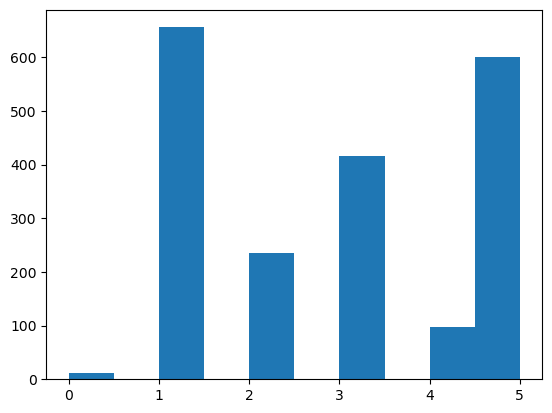

In [130]:
plt.hist(merged_df['NomiantionToInt'], bins=10)
plt.show()

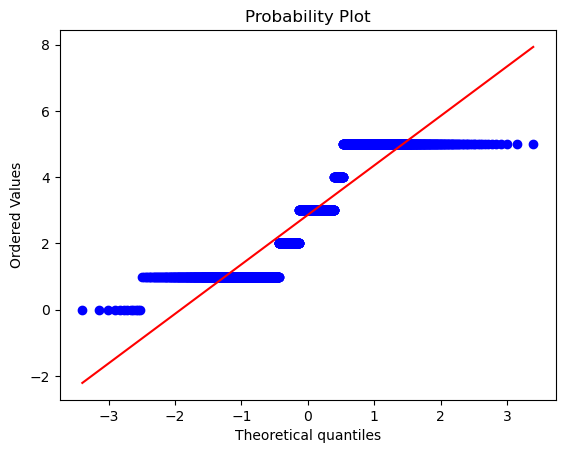

In [131]:
stats.probplot(merged_df['NomiantionToInt'], dist='norm', plot=pylab)
pylab.show()

<Axes: xlabel='NomiantionToInt'>

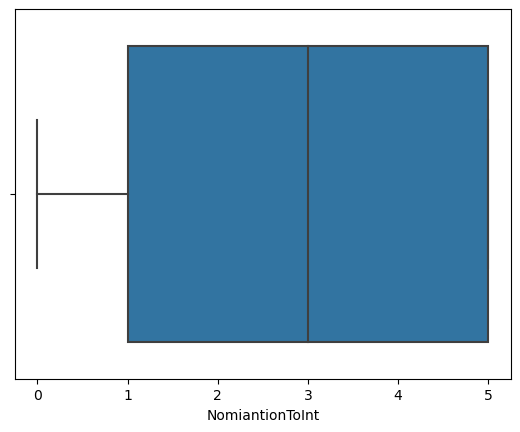

In [132]:
sns.boxplot(x=merged_df['NomiantionToInt'])

C:\Users\essww\AppData\Local\Temp\ipykernel_2264\2577834100.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=merged_df['NomiantionToInt'])


<Axes: ylabel='Density'>

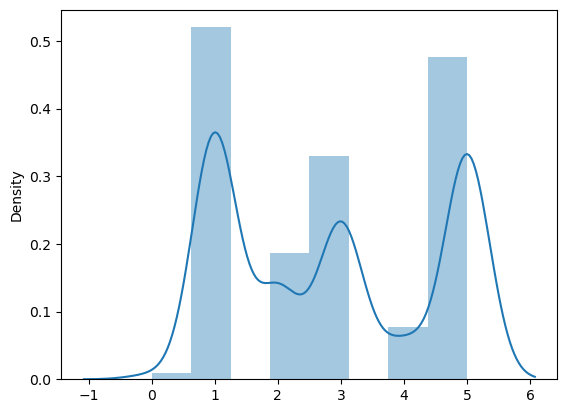

In [133]:
sns.distplot(x=merged_df['NomiantionToInt'])

#### Визуализация зависимостей признаков от целевой переменной

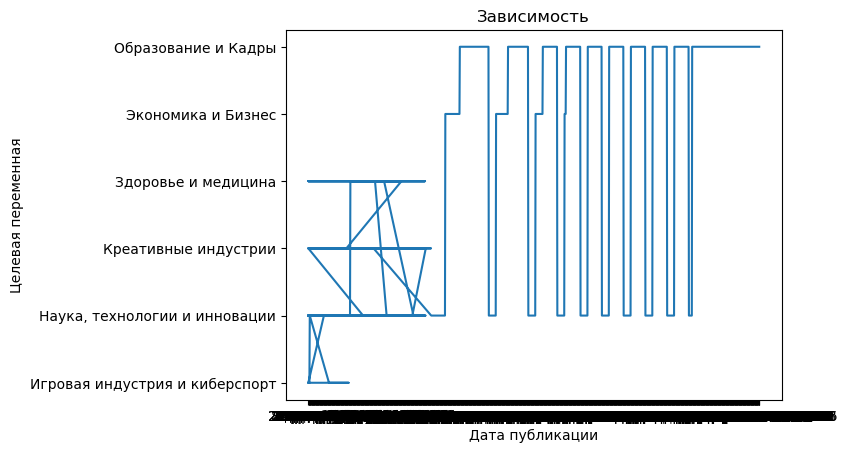

In [134]:
# визализация зависимости даты от номинации
plt.plot(merged_df['DatePublish'], merged_df['Nominations'])
plt.xlabel('Дата публикации')
plt.ylabel('Целевая переменная')
plt.title('Зависимость')
plt.show()

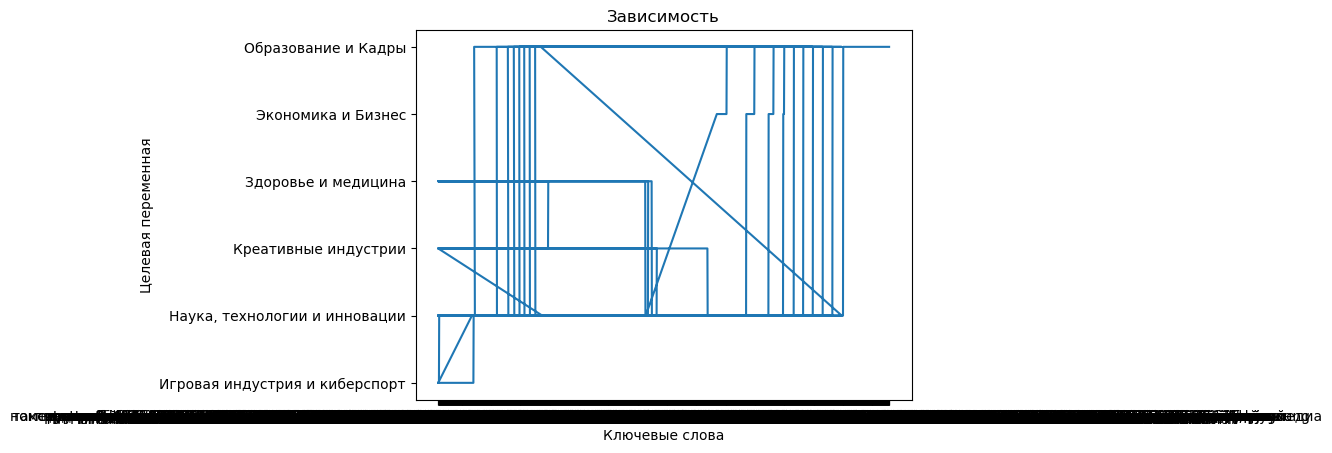

In [135]:
# визализация зависимости ключевых слов от номинации
plt.plot(merged_df['keyword'], merged_df['Nominations'])
plt.xlabel('Ключевые слова')
plt.ylabel('Целевая переменная')
plt.title('Зависимость')
plt.show()

#### Вывод об ассиметрии и мере скошенности

In [136]:
skewness = merged_df['NomiantionToInt'].skew()
kurtosis = merged_df['NomiantionToInt'].kurtosis()


print('Ассиметрия:', skewness)
print('Мера скошенности:', kurtosis)

Ассиметрия: 0.15766003645590604
Мера скошенности: -1.524588526802205


Ассиметрия - это мера симметрии распределения, которая показывает, насколько сильно распределение отличается от симметричного распределения. Значение ассиметрии равно 0, что означает, что распределение близко к симметричному. Мера скошенности - это мера асимметрии распределения, которая показывает, насколько сильно распределение отличается от нормального распределения. Значение меры скошенности равно -1.525, что означает, что распределение имеет сильную левую асимметрию (хвост распределения смещен влево).

In [137]:
# сохраняем DataFrame в файл
merged_df.to_csv(r'Downloads\Report1.csv', index=False, encoding='utf-8')

### 1.6 Подготовка отчета


__1.1 Парсинг данных__ Пункт был выполнен без нареканий. Сначала был выполнен парсинг Json, затем был выполнен парсинг вордовского документа с необходимыми компаниями, после парсинга компаний были выделены компании, которых не было в json файле.
Затем был выполнен парсинг сайта Habr, по поиску из всех номинированных компаний были выделены их статьи и информация о компаниях, также стали известны компании, которых полностью нет ни на Habr, ни в Json, сами компании: Gett, MMA.Metaratings, Метарейтинг, Balance Platform, Дневник МЭШ, скорее всего, причина в том, что эти компании удалили с сайта Habr.

__1.2 Формирование структуры набора данных__ Набор данных успешно был сформирован, все переменные были полностью записаны. Целевыми переменными являются: TitleCompany, TextPostLemat, TextPostToken.

__1.3 Предварительная обработка текстовых данных__ Предварительная обработка данных выполнена без проблем, также были обработаны пропуски. Были созданы самые необходимые признаки TextPostLemat и TextPostToken, в дальнейшем будет производиться работа только с ними. Работа с обработкой данных завершена, данные полностью обработаны.

__1.4 Поиск ключевых слов/n-грамм. Векторизация текста__ Пункт был выполнен успешно, без каких либо проблем. Биграммы, триграммы и векторизация выполнены успешно. А также добавлены как новые признаки. Была выполнена векторизация через CountVectorizer.

    __1.4.1 Выбранный метод биграмм nltk.ngrams__ 
    
    __1.4.2 Выбранный метод триграмм nltk.ngrams__
    
    __1.4.3 Выбранный метод ключевых слов nltk.FreqDist__ 
    
    Каждый из трех методов выбран по причине удобного и простого использования, по сравнению с другими. Были перебраны несколько алгоритмов, некоторые либо работали некорректно, либо работали не так удобно, как nltk.ngrams и nltk.FreqDist.
    
__1.5 Разведочный анализ__ Данный пункт выполнен без каких либо проблем. В пункте был прочитан Json файл, и стали известны какие номинации у каких компаний. Поэтому все названия статей были обработаны для полного соответствия друг с другом, и затем присвоины номинации. Номинация - это целевая переменная, основная работа в дальнейшем будет проходить с ней. Также была выполнена проверка нормальности распределения целевой переменной. Проведена графическая оценка (на основе ключевых слов и даты публикации) и статическая оценка распределения целевой переменной. Сделан вывод о типе распределения, ассиметрии и мере скошенности.


### Вывод

В итоге датафрейм полностью готов к 2-ей Сессии. Номинации присвоены корректно.
